In [1]:
json_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。
首先，请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。

json数据：
```json
{json_data}
```
"""

## **ssdlc 安全检查结果分析器**

### 步骤一，分析统计结果

In [2]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv("./env/.env"))

import dashscope
from http import HTTPStatus
from pprint import pprint
import json

from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatTongyi

llm_model = "qwen-max"

llm = ChatTongyi(temperature=1.0, model=llm_model)

json_analysis_prompt = ChatPromptTemplate.from_template(json_prompt)

with open("./data/keentune-brain-3.0.0/result.json", "r") as f:
    json_data = json.load(f)

response = llm.invoke(json_analysis_prompt.format_messages(json_data=json_data))

print(response.content)

根据你提供的 JSON 数据，我们可以统计出不同严重性级别的漏洞数量。以下是具体的统计步骤：

1. **遍历 `metrics` 字段**：该字段包含了每个文件的扫描结果，其中包含了不同严重性级别的漏洞数量。
2. **累加 `SEVERITY.HIGH`、`SEVERITY.MEDIUM` 和 `SEVERITY.LOW` 的值**：这些值分别代表高危、中危和低危漏洞的数量。

下面是 Python 代码来实现这个统计：

```python
import json

# 假设你的 JSON 数据存储在一个字符串中
json_data = '''{
    "errors": [],
    "generated_at": "2024-11-27T06:55:48Z",
    "metrics": {
        "./brain/__init__.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./brain/algorithm/__init__.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./brain/algorithm/sensitize/__init__.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./brain/algorithm/sensitize/sensiModel.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./brain/algorithm/sensitize/sensitize.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 1},
        "./brain/algorithm/sensitize/sensitizer.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "S

### 步骤二，提取高危扫描结果


In [3]:
high_risk_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。扫描结果格式如下所示：
```json
{{
  "error": [<检查工具报错问题列表>],
  "generated_at": "<生成报告的时间>",
  "metrics": {{
    "<文件名1>": {{
      "CONFIDENCE.HIGH": <当前文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <当前文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<当前文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <当前文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <当前文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <当前文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <当前文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <当前文件中扫描出的问题严重性不确定的个数>,
      "loc": <当前文件代码行数>,
      "nosec": <当前文件nosec打标数量>,
      "skipped_tests": <当前文件跳过的测试数量>
    }},
    "<文件名2>": {{...}},
    ...
    "<文件名n>": {{...}},
    "_totals": {{
      "CONFIDENCE.HIGH": <所有文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <所有文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<所有文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <所有文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <所有文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <所有文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <所有文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <所有文件中扫描出的问题严重性不确定的个数>,
      "loc": <所有文件代码行数>,
      "nosec": <所有文件nosec打标数量>,
      "skipped_tests": <所有文件跳过的测试数量>
    }},
    "results":[<检查工具扫描出的问题列表>
    <example>
    {{
      "code": "3 import json\n4 import requests\n5 import subprocess\n6 import logging\n7 \n",
      "col_offset": 0,
      "end_col_offset": 17,
      "filename": "./bench/common/system.py",
      "issue_confidence": "HIGH",
      "issue_cwe": {{
        "id": 78,
        "link": "https://cwe.mitre.org/data/definitions/78.html"
      }},
      "issue_severity": "LOW",
      "issue_text": "Consider possible security implications associated with the subprocess module.",
      "line_number": 5,
      "line_range": [
        5
      ],
      "more_info": "https://bandit.readthedocs.io/en/1.8.0/blacklists/blacklist_imports.html#b404-import-subprocess",
      "test_id": "B404",
      "test_name": "blacklist"
    }}
    </example>
    ]
  }}
}}
```

你需要做的事情是：
1.请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。
2.输出扫描结果中高危的问题列表。
3.根据扫描结果中metrics记录，帮我找出扫描结果中，存在高危漏洞的文件列表。

要求：
1.根据我的要求帮我完成上述任务，不要做其他事情。
2.不需要输出任何解释，只需要按照我的要求做完事就好。
3.输出必须是json格式，包括扫描结果的总数量和问题列表。
4.输出结果不需要包括```json, ```这样符号。
5.输出格式如下：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

json数据：
```json
{json_data}
```
"""

high_risk_analysis_prompt = ChatPromptTemplate.from_template(high_risk_prompt)

response = llm.invoke(high_risk_analysis_prompt.format_messages(json_data=json_data))

high_risk = response.content
pprint("".join(high_risk))

('{\n'
 '  "total_vulnerabilities": {\n'
 '    "high_severity": 2,\n'
 '    "medium_severity": 6,\n'
 '    "low_severity": 9\n'
 '  },\n'
 '  "high_severity_issues": [\n'
 '    {\n'
 '      "code": "55 def deleteFile(data_name):\\n56     if '
 'os.path.exists(os.path.join(Config.TUNE_DATA_PATH, data_name)):\\n57         '
 'os.system(\\"rm -rf {}\\".format(os.path.join(Config.TUNE_DATA_PATH, '
 'data_name)))\\n",\n'
 '      "col_offset": 8,\n'
 '      "end_col_offset": 85,\n'
 '      "filename": "./brain/common/dataset.py",\n'
 '      "issue_confidence": "HIGH",\n'
 '      "issue_cwe": {\n'
 '        "id": 78,\n'
 '        "name": "Improper Neutralization of Special Elements used in an OS '
 'Command (\'OS Command Injection\')"\n'
 '      },\n'
 '      "issue_severity": "HIGH",\n'
 '      "issue_text": "Starting a process with a shell, possible injection '
 'detected, security issue.",\n'
 '      "line_range": [57],\n'
 '      "more_info": '
 '"https://bandit.readthedocs.io/en/1.8.0/pl

### 步骤三，提取高危问题源码和CWE信息

In [15]:
import os

risk_data = json.loads(high_risk)
risks = {}
for risk_issues in risk_data["high_severity_issues"]:
    risks[risk_issues["filename"]] = {
        "issue_text": risk_issues["issue_text"],
        "code": risk_issues["code"],
        "cwe": risk_issues["issue_cwe"]["id"],
    }

risks["./brain/common/dataset.py"]["source_code_paths"] = [
    os.path.join("./data", "keentune-brain-3.0.0", code_file) 
    for code_file in ["./brain/controller/sensitize.py"]
]

risks["./brain/common/dataset.py"]["source_codes"] = [
    open(source_code_path, "r").read()
    for source_code_path in risks["./brain/common/dataset.py"]["source_code_paths"]
]
risks["./brain/common/dataset.py"]["issue_source_code"] = open(
    os.path.join("./data", "keentune-brain-3.0.0", "./brain/common/dataset.py"), "r"
).read()
# no function calling
risks["./brain/common/system.py"]["source_code_paths"] = []
risks["./brain/common/system.py"]["source_codes"] = []
risks["./brain/common/system.py"]["issue_source_code"] = open(
    os.path.join("./data", "keentune-brain-3.0.0", "./brain/common/system.py"), "r"
).read()

cwd_78_path = os.path.join("./data", "cwe-78.md")

cwe_78 = open(cwd_78_path, "r").read()
from IPython.display import display,Markdown
display(Markdown(
f"""```python
{risks["./brain/common/dataset.py"]["code"]}
```
---
```python
{risks["./brain/common/dataset.py"]["source_codes"][0]}
```
...
---
{cwe_78[:2000]}

...
"""))

```python
55 def deleteFile(data_name):
56     if os.path.exists(os.path.join(Config.TUNE_DATA_PATH, data_name)):
57         os.system("rm -rf {}".format(os.path.join(Config.TUNE_DATA_PATH, data_name)))

```
---
```python
# Copyright (c) 2021-2023 Alibaba Cloud Computing Ltd.
# SPDX-License-Identifier: MulanPSL-2.0
import os
import json
import signal
import logging

from tornado.web import RequestHandler
from brain.common.dataset import listData, deleteFile
from brain.controller.process import SensitizeProcess

logger = logging.getLogger('common')

SENSI_PROC = None


def shutdown():
    global SENSI_PROC
    if SENSI_PROC is None:
        return
    
    try:
        logger.info("kill sensitize process: pid = {}".format(SENSI_PROC.pid))
        os.kill(SENSI_PROC.pid, signal.SIGKILL) 
    
    except ProcessLookupError as e:
        logger.warning("can not find sensitize process: {}".format(e))
        del SENSI_PROC
        SENSI_PROC = None
        
    else:
        del SENSI_PROC
        SENSI_PROC = None


class SensitizeHandler(RequestHandler):
    def post(self):
        global SENSI_PROC

        request_data = json.loads(self.request.body)
        logger.debug("get sensitize request: {}".format(request_data))

        try:
            shutdown()
        except Exception as e:
            logger.error("fail to kill sensitize process: {}".format(e))
            self.write(json.dumps({
                "suc": False,
                "msg": "fail to kill sensitize process: {}".format(e)}))
            self.finish()

        try:
            SENSI_PROC = SensitizeProcess(
                trials      = int(request_data['trials']),
                data_name   = request_data['data'],
                explainer   = request_data['explainer'],
                response_ip = request_data['resp_ip'],
                response_port = request_data['resp_port']
            )
            SENSI_PROC.start()
        
        except Exception as e:
            logger.error("Failed to start sensitize process: {}".format(e))
            self.write(json.dumps({
                "suc" : False, 
                "msg": "Failed to start sensitize process: {}".format(e)}))
            self.finish()

        else:
            logger.info("sensitize response, process running")
            self.write(json.dumps({"suc" : True, "msg": ""}))
            self.finish()


class TerminateHandler(RequestHandler):
    def get(self):
        try:
            shutdown()
        except Exception as e:
            logger.error("fail to kill sensitize process: {}".format(e))


class DataDeleteHandler(RequestHandler):
    def post(self):
        try:
            data = json.loads(self.request.body)
            logger.info("delete data requests: {}".format(data))
            deleteFile(data['data'])

        except Exception as e:
            logger.error("delete data error: {}".format(e))
            self.write(json.dumps({"suc": False, "msg": "{}".format(e)}))
            self.finish()

        else:
            self.write(json.dumps({"suc": True, "msg": ""}))
            self.finish()


class AvaliableHandler(RequestHandler):
    def get(self):
        try:
            data_list = listData()
            logger.info("get avaliable data: {}".format(data_list))

        except Exception as e:
            logger.error("get avaliable error: {}".format(e))
            self.write(json.dumps({"suc": False, "msg": "{}".format(e)}))
            self.finish()
        
        else:
            self.write(json.dumps({
                "suc"   : True,
                "data"  : data_list,
                "tune"  : ["random", "hord", "lamcts", "bgcs"],
                "explainer" :['Xsen', 'SHAPKernel', 'XGBTotalGain', 'LASSO','MI','GP']
            }))
            self.finish()

```
...
---
## CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
--------------------------------------------------------------------------------------------------

Weakness ID: 78

------------------

### Description

The product constructs all or part of an OS command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended OS command when it is sent to a downstream component.


### Extended Description

This weakness can lead to a vulnerability in environments in which the attacker does not have direct access to the operating system, such as in web applications. Alternately, if the weakness occurs in a privileged program, it could allow the attacker to specify commands that normally would not be accessible, or to call alternate commands with privileges that the attacker does not have. The problem is exacerbated if the compromised process does not follow the principle of least privilege, because the attacker-controlled commands may run with special system privileges that increases the amount of damage.

There are at least two subtypes of OS command injection:

*   The application intends to execute a single, fixed program that is under its own control. It intends to use externally-supplied inputs as arguments to that program. For example, the program might use system("nslookup \[HOSTNAME\]") to run nslookup and allow the user to supply a HOSTNAME, which is used as an argument. Attackers cannot prevent nslookup from executing. However, if the program does not remove command separators from the HOSTNAME argument, attackers could place the separators into the arguments, which allows them to execute their own program after nslookup has finished executing.
*   The application accepts an input that it uses to fully select which program to run, as well as which commands to use. The application simply redirects this entire command

...


### 步骤四，提取高危源码的调用关系

### 分析结果

#### 1. 问题代码段在源码文件中属于哪个函数
根据提供的JSON数据和源码内容，我们可以确定以下两个高危问题所在的函数：

- **问题1**:
  - 文件路径: `./brain/common/dataset.py`
  - 问题代码段: 
    ```python
    def deleteFile(data_name):
        if os.path.exists(os.path.join(Config.TUNE_DATA_PATH, data_name)):
            os.system("rm -rf {}".format(os.path.join(Config.TUNE_DATA_PATH, data_name)))
    ```
  - 所属函数: `deleteFile`

- **问题2**:
  - 文件路径: `./brain/common/system.py`
  - 问题代码段: 
    ```python
    result = subprocess.run(
        command,
        shell=True,
        close_fds=True,
        cwd=cwd,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE
    )
    ```
  - 所属函数: 由于没有提供`system.py`的完整源码，我们无法直接确定这个代码段所属的具体函数。但从上下文来看，这段代码很可能是一个使用了`subprocess.run`的函数。

#### 2. 函数调用链
根据提供的函数调用链所在源码内容，我们可以分析出`deleteFile`函数的调用链：

- **`deleteFile`函数调用链**:
  - `DataDeleteHandler.post` 方法调用了 `deleteFile` 函数。
  - 具体调用链如下：
    ```python
    class DataDeleteHandler(RequestHandler):
        def post(self):
            try:
                da

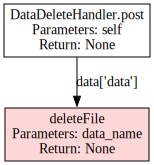

In [19]:
from graphviz import Source
from IPython.display import SVG, display

parse_high_risk_call_graph_template = """你是一个精通python语言分析的专家，我会给你一段含有python代码高危问题的json数据，数据格式为：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

python代码高危问题json数据为：
{high_risk}

同时我还会提供源码内容以供你进行python的分析：
- 高危问题所在的源码为
```python
{issue_source_code}
```
- 函数调用链所在的源码
```python
{source_code}
```

你需要做的事情是：
1.找出问题代码段在源码文件中属于哪个函数
2.找出第1步中函数调用链

要求：
1.如果提供的调用链所在的源码内容为空，则表示函数调用链为空，可以在分析结果中直接返回"No function calling of this issue"
"""

parse_high_risk_call_graph_prompt = ChatPromptTemplate.from_template(
    parse_high_risk_call_graph_template
)

high_risk_call_graphs = {}

for issue_file, risk in risks.items():
    high_risk_call_graphs[issue_file] = []
    issue_source_code = risk["issue_source_code"]
    for source_code in risk["source_codes"]:
        response = llm.invoke(
            parse_high_risk_call_graph_prompt.format_messages(
                high_risk=high_risk,
                issue_source_code=issue_source_code,
                source_code=source_code,
            )
        )

        high_risk_call_graph = response.content
        high_risk_call_graphs[issue_file].append(high_risk_call_graph)
        print(high_risk_call_graph)
        print("---------\n")

        dot_graph_description = """你是一个精通DOT语言描述代码调用关系图（call graph）的专家，请根据我给出的python代码高危问题json数据和高危问题所在函数及其调用点数据，用dot语言描述该代码调用关系图。

**要求：**
1.你不需要做其他任何事情，只需要用dot语言把代码调用关系图出来就可以；
2.你可以根据自己对dot语言的理解进行编写生成dot语言描述，但请确保你的描述符合dot语言语法，并且能正确描述出代码调用关系图；
3.你的描述需要包含函数名、函数参数、函数返回值、函数调用链、参数样例等必要信息，但不要包含函数体；
4.如果dot语言描述过程中遇到存在高危问题的函数时，通过设置节点颜色为淡红色的方式来突出该节点，其他节点保持黑底白字即可；
5.生成的内容除了dot语言之外不要包括其他任何内容，也不要包含```dot和```这类非dot语言语法的内容；


python代码高危问题json数据为：
{high_risk}

高危问题所在函数及其调用点数据为：
{high_risk_call_graph}
"""
        dot_graph_prompt = ChatPromptTemplate.from_template(dot_graph_description)
        response = llm.invoke(dot_graph_prompt.format_messages(high_risk=high_risk, high_risk_call_graph=high_risk_call_graph))
        dot_graph = response.content
        dot_call_graph = Source(dot_graph, filename="output-graph.gv", format="svg")
        display(SVG(dot_call_graph.pipe().decode("utf-8")))

In [20]:
for file, graph in high_risk_call_graphs.items():
    print(file)
    print("---")
    print(graph)

./brain/common/dataset.py
---
['### 分析结果\n\n#### 1. 问题代码段在源码文件中属于哪个函数\n根据提供的JSON数据和源码内容，我们可以确定以下两个高危问题所在的函数：\n\n- **问题1**:\n  - 文件路径: `./brain/common/dataset.py`\n  - 问题代码段: \n    ```python\n    def deleteFile(data_name):\n        if os.path.exists(os.path.join(Config.TUNE_DATA_PATH, data_name)):\n            os.system("rm -rf {}".format(os.path.join(Config.TUNE_DATA_PATH, data_name)))\n    ```\n  - 所属函数: `deleteFile`\n\n- **问题2**:\n  - 文件路径: `./brain/common/system.py`\n  - 问题代码段: \n    ```python\n    result = subprocess.run(\n        command,\n        shell=True,\n        close_fds=True,\n        cwd=cwd,\n        stderr=subprocess.PIPE,\n        stdout=subprocess.PIPE\n    )\n    ```\n  - 所属函数: 由于没有提供`system.py`的完整源码，我们无法直接确定这个代码段所属的具体函数。但从上下文来看，这段代码很可能是一个使用了`subprocess.run`的函数。\n\n#### 2. 函数调用链\n根据提供的函数调用链所在源码内容，我们可以分析出`deleteFile`函数的调用链：\n\n- **`deleteFile`函数调用链**:\n  - `DataDeleteHandler.post` 方法调用了 `deleteFile` 函数。\n  - 具体调用链如下：\n    ```python\n    class DataDeleteHandler(Request

### 步骤五，CWE危险等级分析

In [22]:
cwe_severity_analysis_template = """你是一个精通python语言的安全工程师，你精通CWE漏洞的利用。我会给出一段有高危问题的源码和高危问题所在函数的调用链，同时我还会给出高危问题的CWE信息，
CWE信息包括：
- CWE名称
- CWE编号（Weakness ID）
- CWE描述（Description， Extended Description）
- CWE常见的后果（Common Consequence）
- CWE修复建议（Potential Mitigations），修复建议会根据不同阶段Phase给出办法，例如：架构设计阶段Phase: Architecture and Design

你的任务是根据CWE信息对高危问题进行分析：
1.根据高危问题以及其函数调用链的信息，结合CWE信息，给出该问题的影响和后果；
2.根据函数调用链信息以及源码，结合CWE描述和修复建议等信息，给出该高危问题被外部调用者利用的可能性和难易程度；
3.根据CWE的修复建议、函数调用链、该高危问题被利用的可能性和难易程度，给出该高危问题的修复建议；
4.根据上面步骤1，2，3的分析结果，给出该高危问题的分析总结；

要求：
- 输出结果的标题为"SSDLC高危问题分析报告"；
- 需要按照分析过程进行内容输出，包括：1.问题的影响和后果；2.利用的可能性和难易程度；3.修复建议；4.分析总结；
- 输出结果时需要按照分析过程包括你使用的数据来源，分析方法，以及你如何结合CWE信息对问题的影响和后果进行评估；
- 给出的修复建议中要考虑函数调用链上每个函数的参数和返回值；
- 为了方便快速识别和理解该高危问题，高危问题分析总结中，根据该高危问题被外部调用者利用的可能性是由高到低、难易程度由容易到困难以及修复问题的难度由简单到困难，给出总结评估打分；

高危问题所在源码：
```python
{source_code}
```

高危问题所在函数调用链情况：
```python
{high_risk_call_graph}
```

函数调用链所在的源码：
```python
{issue_source_code}
```

CWE信息如下：
```markdown
{cwe_info}
```
"""
all_cwe_severity_analysis = {}
cwe_severity_analysis_prompt = ChatPromptTemplate.from_template(
    cwe_severity_analysis_template
)
for file, call_graph in high_risk_call_graphs.items():
    for idx, source_code in enumerate(risks[file]["source_codes"]):
        high_risk_call_graph = call_graph[idx]
        issue_source_code = risks[file]["issue_source_code"]
        response = llm.invoke(
            cwe_severity_analysis_prompt.format_messages(
                source_code=source_code,
                issue_source_code=issue_source_code,
                high_risk_call_graph=high_risk_call_graph,
                cwe_info=cwe_78,
            )
        )

        cwe_severity_analysis = response.content
        all_cwe_severity_analysis[file] = cwe_severity_analysis

### 步骤六，生成ssdlc扫描分析报告

In [23]:
for souce_code_path, cwe_severity_analisys in all_cwe_severity_analysis.items():
    display(Markdown(f"---\n### {souce_code_path}\n---"))
    display(Markdown(cwe_severity_analysis))

---
### ./brain/common/dataset.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 问题代码段
```python
def deleteFile(data_name):
    if os.path.exists(os.path.join(Config.TUNE_DATA_PATH, data_name)):
        os.system("rm -rf {}".format(os.path.join(Config.TUNE_DATA_PATH, data_name)))
```

### CWE信息
- **CWE名称**: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
- **CWE编号**: 78
- **CWE描述**: 该产品使用来自上游组件的外部影响输入来构建全部或部分操作系统命令，但没有中和或错误地处理特殊元素，这些元素可能在发送到下游组件时修改预期的操作系统命令。
- **常见的后果**: 攻击者可以执行未经授权的操作系统命令，这可能导致产品被禁用、读取和修改数据、隐藏活动等。

### 影响和后果
- **机密性**: 攻击者可以读取敏感文件或目录。
- **完整性**: 攻击者可以修改文件或目录。
- **可用性**: 攻击者可以通过执行恶意命令使系统崩溃或重启。
- **非否认性**: 由于命令是由应用程序直接执行的，任何恶意活动可能看起来像是来自应用程序或其所有者。

## 2. 利用的可能性和难易程度

### 函数调用链
- `DataDeleteHandler.post` 方法调用了 `deleteFile` 函数。
- 具体调用链如下：
  ```python
  class DataDeleteHandler(RequestHandler):
      def post(self):
          try:
              data = json.loads(self.request.body)
              logger.info("delete data requests: {}".format(data))
              deleteFile(data['data'])  # 调用 deleteFile 函数
          except Exception as e:
              logger.error("delete data error: {}".format(e))
              self.write(json.dumps({"suc": False, "msg": "{}".format(e)}))
              self.finish()
          else:
              self.write(json.dumps({"suc": True, "msg": ""}))
              self.finish()
  ```

### 利用的可能性
- **可能性**: 高
  - `deleteFile` 函数接收来自客户端的 `data_name` 参数，并将其直接用于构造 `os.system` 命令。攻击者可以通过构造特殊的 `data_name` 参数来注入恶意命令。
- **难易程度**: 容易
  - 由于 `os.system` 直接执行字符串形式的命令，攻击者只需构造一个包含恶意命令的 `data_name` 参数即可利用该漏洞。

## 3. 修复建议

### 修复建议
- **架构设计阶段**:
  - 使用库函数而不是外部进程来实现所需功能。
  - 将数据尽可能地保留在本地，避免将数据传递给客户端。
  - 在服务器端重复进行客户端的安全检查，以防止绕过客户端检查。

- **实施阶段**:
  - 使用参数化方法来调用外部命令，例如使用 `subprocess.run` 并传递参数列表。
  - 对输入进行严格的验证和过滤，只允许特定的字符集。
  - 使用白名单机制，限制可接受的输入值。

### 修复步骤
1. **替换 `os.system` 为 `subprocess.run`**:
   ```python
   import subprocess

   def deleteFile(data_name):
       data_path = os.path.join(Config.TUNE_DATA_PATH, data_name)
       if os.path.exists(data_path):
           try:
               subprocess.run(['rm', '-rf', data_path], check=True)
           except subprocess.CalledProcessError as e:
               logger.error(f"Failed to delete file: {e}")
   ```

2. **对 `data_name` 进行严格的输入验证**:
   ```python
   import re

   def validate_data_name(data_name):
       if not re.match(r'^[a-zA-Z0-9_\-]+$', data_name):
           raise ValueError("Invalid data name")

   def deleteFile(data_name):
       validate_data_name(data_name)
       data_path = os.path.join(Config.TUNE_DATA_PATH, data_name)
       if os.path.exists(data_path):
           try:
               subprocess.run(['rm', '-rf', data_path], check=True)
           except subprocess.CalledProcessError as e:
               logger.error(f"Failed to delete file: {e}")
   ```

3. **在 `DataDeleteHandler` 中增加输入验证**:
   ```python
   class DataDeleteHandler(RequestHandler):
       def post(self):
           try:
               data = json.loads(self.request.body)
               data_name = data['data']
               validate_data_name(data_name)
               logger.info("delete data requests: {}".format(data))
               deleteFile(data_name)
           except Exception as e:
               logger.error("delete data error: {}".format(e))
               self.write(json.dumps({"suc": False, "msg": "{}".format(e)}))
               self.finish()
           else:
               self.write(json.dumps({"suc": True, "msg": ""}))
               self.finish()
   ```

## 4. 分析总结

### 总结评估打分
- **利用的可能性**: 高
- **难易程度**: 容易
- **修复难度**: 简单

### 分析总结
- **问题的影响和后果**: 该问题可能导致严重的安全风险，包括数据泄露、数据篡改和系统崩溃。
- **利用的可能性和难易程度**: 该问题很容易被攻击者利用，因为 `os.system` 直接执行用户输入的字符串。
- **修复建议**: 通过使用 `subprocess.run` 和严格的输入验证，可以有效防止命令注入攻击。修复步骤简单且易于实施。

通过上述分析，我们强烈建议尽快修复该高危问题，以防止潜在的安全威胁。